# Example of Integrated Gradients for tabular data

## Introduction

Integrated Gradients is introduced by this paper, Axiomatic Attribution for Deep Networks. (https://arxiv.org/abs/1703.01365) Google also presented this algorithm to explain attributions of image data in https://www.tensorflow.org/tutorials/interpretability/integrated_gradients. However, one of the limitations is that this sample code is for image data, so it cannot be applied directly to tabular data. The goal of this document is to convert the source code into a modified version which works on tabular data with small changes.

The importance of explaining outputs of predictions from ML models is becoming more and more greater. Especially, for many business cases, decision makers want to know how a ML model makes its outcome in order to avoid potential problems or to understand how each variable relates to a response variable. A lot of data sets in the business environment consist of tabular data, so Integrated Gradients for tabular data will be very useful for those who want to explain their deep learning models.

In this document, I am going to show you how to use Integrated Gradients for tabular data. I created a Python module, **igtab**, that implemented the algorithm especially for tabular data. The source code is available in this github.


## Load libraries

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import *
from tqdm import tqdm

## Prepare data

### Load the bank marketing data set 

(https://archive.ics.uci.edu/ml/datasets/bank+marketing).

In [5]:
bank = pd.read_csv('bank.csv', sep=';')

In [6]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [7]:
categorical_feature_names = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
numerical_feature_names = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
binary_feature_names = ['y', 'default', 'housing', 'loan']
target_feature_name = 'y'

In [8]:
bank_bin = bank[binary_feature_names].applymap(lambda x: 1 if x == 'yes' else 0)
bank_num = bank[numerical_feature_names]
bank_cat = pd.get_dummies(bank[categorical_feature_names])

In [9]:
df = pd.concat([bank_bin, bank_num, bank_cat], axis=1)
df.shape

(4521, 48)

In [10]:
df.head()

,y,default,housing,loan,age,balance,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0,0,0,30,1787,79,1,-1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,1,1,33,4789,220,1,339,4,...,0,0,1,0,0,0,1,0,0,0
2,0,0,1,0,35,1350,185,1,330,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,1,30,1476,199,4,-1,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,1,0,59,0,226,1,-1,0,...,0,0,1,0,0,0,0,0,0,1


### Split data

In [17]:
col_x = df.columns[1:]
col_y = df.columns[0]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(df[col_x], df[col_y], shuffle=True, random_state=0, train_size=0.8)

### Scale data

In [19]:
x_scaler = StandardScaler()
x_train_std = x_scaler.fit_transform(x_train)
x_test_std = x_scaler.transform(x_test)

# y_scaler = StandardScaler()
# y_train_std = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
# y_test_std = y_scaler.transform(y_test.to_numpy().reshape(-1, 1))

## Create a simple neural network model

To generate outputs of Integrated Gradients, we need a DL model.

In [25]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_dim=df.shape[-1]-1))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(64, use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(64, use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('sigmoid'))
# model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                1536      
                                                                 
 activation_5 (Activation)   (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2048      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [26]:
epochs = 100
batch_size = 128
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True, patience=20)
hist = model.fit(x_train_std, y_train, epochs=epochs, batch_size=batch_size, 
                 validation_data=(x_test_std, y_test), callbacks=[reduce_lr, early_stop])

Epoch 1/100
29/29 [==============================] - 2s 12ms/step - loss: 0.5554 - accuracy: 0.7544 - val_loss: 0.6015 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3464 - accuracy: 0.8935 - val_loss: 0.5028 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.2845 - accuracy: 0.8996 - val_loss: 0.4312 - val_accuracy: 0.8873 - lr: 0.0010
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.2544 - accuracy: 0.9057 - val_loss: 0.3738 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 0.2338 - accuracy: 0.9090 - val_loss: 0.3305 - val_accuracy: 0.8873 - lr: 0.0010
Epoch 6/100
29/29 [==============================] - 0s 4ms/step - loss: 0.2171 - accuracy: 0.9137 - val_loss: 0.3019 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.

In [27]:
y_pred = model.predict(x_test_std).reshape(-1)

In [28]:
print(classification_report(y_pred > 0.5, y_test, digits=4))

              precision    recall  f1-score   support

       False     0.9811    0.9068    0.9425       858
        True     0.2857    0.6809    0.4025        47

    accuracy                         0.8950       905
   macro avg     0.6334    0.7938    0.6725       905
weighted avg     0.9450    0.8950    0.9144       905




## Examples of Integrated Gradients

### Generate contributions of each variable

Import **igtab** to generate results of explaining the ML model.

In [43]:
from igtab import Explainer

In [ ]:
# remove the last layer, sigmoid activation.
model2 = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [68]:
explainer = Explainer(model=model2, m_steps=50, type='sigmoid')

In [69]:
res = explainer.ig_values(x_test_std)

100%|██████████| 905/905 [00:06<00:00, 143.61it/s]


In [70]:
res.shape

(905, 47)

The result has been created with the shape 4128 by 8.


### Explaining meanings of generated contributions 

Convert the result into a pandas dataframe.

In [72]:
df_res = pd.DataFrame(res, columns=df.columns[1:])

In [73]:
df_res.head()

,default,housing,loan,age,balance,duration,campaign,pdays,previous,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,-0.000010,-0.003251,0.003575,0.001090,0.000177,0.017938,-0.000589,-0.003464,0.000396,-0.001260,...,-0.001756,-0.001562,0.001130,0.000921,-0.000799,0.000316,-0.000384,0.000159,-0.002685,0.003127
1,-0.000447,0.001910,0.001502,-0.002482,0.002709,-0.004865,-0.000356,0.000206,0.000430,0.000779,...,-0.000321,-0.000260,0.002538,0.001750,-0.000099,0.000256,-0.000359,0.000613,-0.001058,-0.000462
2,-0.006094,-0.040100,0.007026,-0.012875,0.010489,0.181904,0.016328,-0.011612,0.001745,0.003810,...,-0.003866,-0.002842,0.014655,-0.017364,-0.001332,0.000352,0.004598,-0.007937,-0.003161,0.019850
3,-0.001382,-0.012702,-0.017615,-0.000906,-0.002344,-0.000249,-0.000940,0.004731,0.007934,0.018602,...,0.004443,-0.000239,0.008088,0.037697,-0.002107,0.002162,0.000821,-0.001769,-0.002420,0.004970
4,-0.000433,0.000636,0.002395,-0.000068,0.000239,-0.005497,-0.000159,-0.001732,-0.001047,0.003631,...,0.003269,-0.000982,0.008653,0.018984,-0.001583,0.000748,0.001597,-0.001564,-0.001959,-0.001069


Now, we are able to see contributions of each variable to each row (observation).

The sum of all contributions of each row is the corresponding predicted y value approximately.

## Visualization


In order to visualize the result, we can reuse visualizing functions from SHAP.

In [77]:
import shap

### Summary Plot

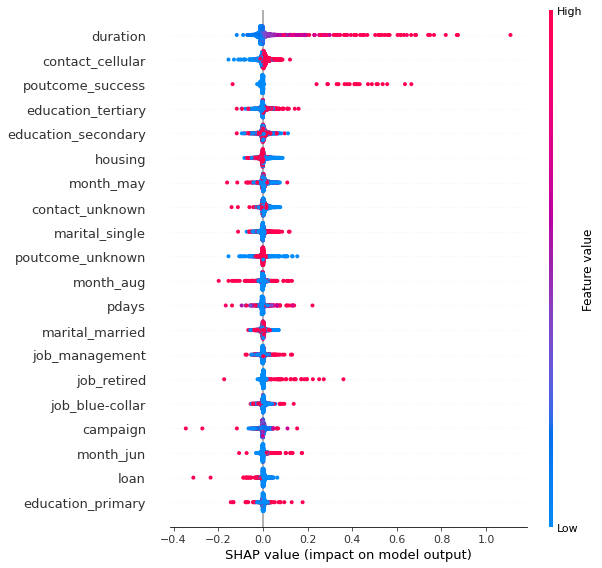

In [101]:
shap.summary_plot(res, x_test)

### Force plot

In [81]:
x_test = x_test.reset_index(drop=True)

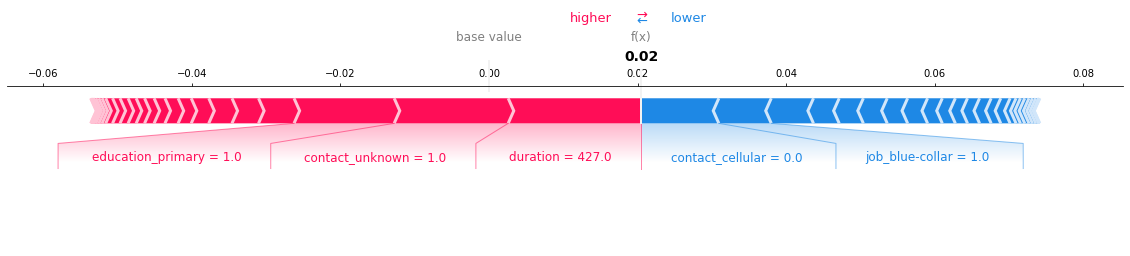

In [91]:
shap.force_plot(0, res[0, :], x_test.iloc[0, :], matplotlib=True)

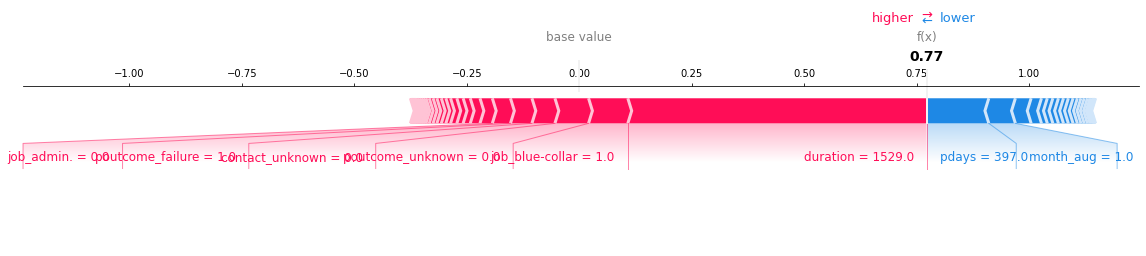

In [99]:
ind = np.where(y_pred > 0.7)[0]
shap.force_plot(0, res[ind[0], :], x_test.iloc[ind[0], :], matplotlib=True)

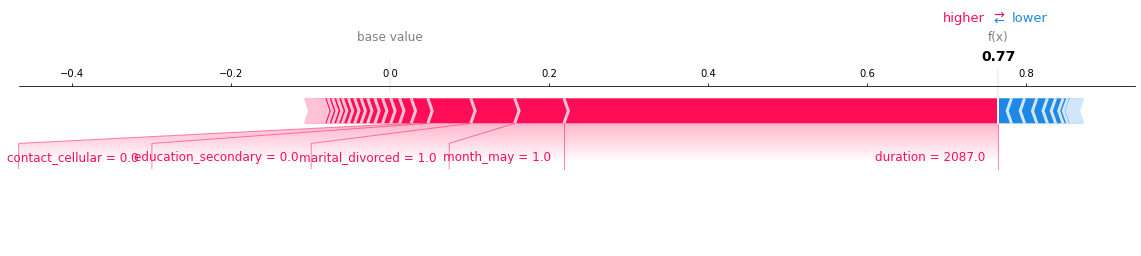

In [100]:
shap.force_plot(0, res[ind[1], :], x_test.iloc[ind[1], :], matplotlib=True)